The concepts we've discussed so far provide us a space of possible descriptions of the world coming from probability theory, but they do not give us a way of grounding that description, thereby imbuing it with content. This is the role of statistics in general and [statistical inference](https://en.wikipedia.org/wiki/Statistical_inference) in particular. A good bit of this course will cover different forms of statistical inference. In this section, my aim is to give you a taste of two of the major forms of statistical inference we'll use throughout the course in increasing more complex forms: [frequentist inference](https://en.wikipedia.org/wiki/Frequentist_inference) and [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference). Unless you have explicitly been introduced to Bayesian inference, frequentist inference is probably the form you are most familiar with through the use of constructs like [$p$-values](https://en.wikipedia.org/wiki/P-value) and [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval).

The overall goal of statistical inference is to find a good description of (some property of) a *population* in terms of probability distributions. The notion of population is very abstract; it could be basically any of the things we might be interested in defining a probability model for: formant values, vowels, well-formed strings of phonemes, morphemes, words, etc. We will generally start out with some assumptions about the family of distributions that might best describe the population and then on the basis of data sampled from the population attempt to determine which distribution in the family is the best description.

## Running example: pronoun case

As a running example, I'll consider a case where $X_i$ maps a pronoun token $i$ to an indicator of whether it is accusative or not–i.e. the Bernoulli random variable we discussed [here](random-variables-and-probability-distributions.html#finite-distributions). 

In [1]:
pronouns = frozenset({
    "i", "me", 
    "you", 
    "they", "them", 
    "it", 
    "she", "her", 
    "he", "him", 
    "we", "us",
})

pronouns_acc = frozenset({"me", "you", "them", "her", "him", "it", "us"})
pronouns_nonacc = frozenset({"i", "you", "they", "she", "he", "it", "we"})

For data, we'll use the [Universal Dependencies English Web Treebank](https://universaldependencies.org/treebanks/en_ewt/index.html).^[We won't use it here, but the pronoun relative frequencies visualized [here](random-variables-and-probability-distributions.ipynb#discrete-probability-distributions) are derived from `pronoun_count` below using `{p: c / pronoun_count.total() for p, c in pronoun_count.items()}`.] I'll use this data throughout, often without comment.

In [2]:
from urllib.request import urlopen
from collections import Counter
from numpy import array

data = []

case_pronoun = {
    "[+acc]": [],
    "[-acc]": []
}

pronoun_count = Counter()

ud_ewt_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"

with urlopen(ud_ewt_url) as ud_ewt_url:
    for i, l in enumerate(ud_ewt_url):
        l = l.decode()
        
        if l[0] != "#" and l.strip():
            l = l.split()
            word = l[1].lower()
            
            if word not in pronouns:
                continue
            
            if word in pronouns_acc - pronouns_nonacc:
                data.append(1)
                case_pronoun["[+acc]"].append(word)
                pronoun_count[word] += 1
            elif word in pronouns_nonacc - pronouns_acc:
                data.append(0)
                case_pronoun["[-acc]"].append(word)
                pronoun_count[word] += 1
            elif l[7] == "nsubj":
                data.append(0)
                case_pronoun["[-acc]"].append(word)
                pronoun_count[word+"_[-acc]"] += 1
            else:
                data.append(1)
                case_pronoun["[+acc]"].append(word)
                pronoun_count[word+"_[+acc]"] += 1
                
data = array(data)

I'll assume that $X_i$ is independent of $X_j$ for all $i \neq j$. In this case, we say that the collection of random variables $\{X_1, X_2, \ldots\}$ is independent and identically distributed (iid), which I will denote by.

$$X_i \sim \text{Bern}(\pi)$$

Here, our description of our population is $\text{Bern}(\pi)$ and $X_i$ is a random variable corresponding to the $i^{th}$ sample we've taken from the population. 

One thing we might be interested in inferring is what the value of $\pi$ is. We'll discuss two broad families of approaches to doing this: [frequentist inference](#frequentist-inference) and [Bayesian inference](#bayesian-inference).

## Frequentist inference

In frequentist inference, we assume that $\pi$ is a fixed value–some aspect of the world we are attempting to discover (or at least approximate). One popular way to attempt to approximate (or *estimate*) this value is through use of the likelihood function $\mathcal{L}_\mathbf{x}(\pi) = p_{X_1, X_2, \ldots, X_N}(\mathbf{x} = x_1, x_2, \ldots, x_N; \pi)$.^[I'm using $\mathcal{L}_\mathbf{x}(\pi)$ to emphasize that $\mathcal{L}$ is parameterized by $\mathbf{x}$. Another notation, which means the same thing but which I think is initially more confusing, is $\mathcal{L}(\pi \mid \mathbf{x})$. I will return to why this notation makes sense in a second.] One common way to use the likelihood function in this way is [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE). In MLE, we derive an estimate $\hat\pi$ by...maximizing the likelihood.

$$\begin{align*}\hat\pi &= \arg_\pi\max\mathcal{L}_\mathbf{x}(\pi)\\ &= \arg_\pi\max p_{X_1, X_2, \ldots, X_N}(\mathbf{x}; \pi)\end{align*}$$

Because $X_1, X_2, \ldots, X_N$ are iid by assumption (whether we observe a high vowel on the $i^{th}$ observation doesn't depend on whether we observed it on any other), we can express this quantity as:

$$\begin{align*}\hat\pi &= \arg_\pi\max p_{X_1, X_2, \ldots}(\mathbf{x}; \pi)\\ &= \arg_\pi\max \prod_{i=1}^N p_{X_i}(x_i; \pi)\\ &= \arg_\pi\max \prod_{i=1}^N \text{Bern}(x_i; \pi)\\ &= \arg_\pi\max \prod_{i=1}^N \pi^{x_i}(1-\pi)^{1-x_i}\\\end{align*}$$

To make this form easier to work with, we will often maximize the log of the likelihood rather than the likelihood directly. (Equivalently, we will sometimes minimize the negative of the log-likelihood.) Taking the logarithm gives us the same result for the argmax, since logarithms are [monotone increasing](https://en.wikipedia.org/wiki/Monotonic_function).

$$\begin{align*}\hat\pi &= \arg_\pi\max \mathcal{L}_\mathbf{x}(\pi)\\ &= \arg_\pi\max\log\mathcal{L}_\mathbf{x}(\pi) \\ &= \arg_\pi\max \log\prod_{i=1}^N \pi^{x_i}(1-\pi)^{1-x_i}\\ &= \arg_\pi\max \sum_{i=1}^N \log\left( \pi^{x_i}(1-\pi)^{1-x_i}\right)\\ &= \arg_\pi\max \sum_{i=1}^N x_i \log \pi + (1-x_i)\log(1-\pi)\\\end{align*}$$

One reason to express the maximization in terms of the log-likelihood, rather than the likelihood, is that it allows us to exchange a product for a sum. This sum makes it easier to compute the derivative, which we will use to maximize $\pi$....

$$\begin{align*}\frac{\mathrm{d}}{\mathrm{d}\pi}\log\mathcal{L}_\mathbf{x}(\pi) &= \frac{\mathrm{d}}{\mathrm{d}\pi}\sum_{i=1}^N x_i \log \pi + (1-x_i)\log(1-\pi)\\ &= \sum_{i=1}^N \frac{\mathrm{d}}{\mathrm{d}\pi} x_i \log \pi + (1-x_i)\log(1-\pi)\\ &= \sum_{i=1}^N \frac{x_i -\pi}{p(1-\pi)}\\ &= \sum_{i=1}^N \frac{x_i}{\pi(1-\pi)} - \frac{1}{1-\pi}\\ &= \left[\frac{1}{\pi(1-\pi)}\sum_{i=1}^N x_i\right] - \frac{N}{1-\pi}\end{align*}$$

...by setting it to zero. 

$$\begin{align*}\left[\frac{1}{\hat\pi(1-\hat\pi)}\sum_{i=1}^N x_i\right] - \frac{N}{1-\hat\pi} &= 0 \\ \frac{1}{\hat\pi(1-\hat\pi)}\sum_{i=1}^N x_i &= \frac{N}{1-\hat\pi} \\ \sum_{i=1}^N x_i &= N\hat\pi \\ \frac{\sum_{i=1}^N x_i}{N} &= \hat\pi \\ \end{align*}$$

Thus, the maximum likelihood estimate $\hat\pi$ for a particular set of samples $x_1, x_2, \ldots, x_N$ is simply the *sample mean* for $X_1, X_2, \ldots, X_N$: $\frac{\sum_{i=1}^N x_i}{N}$ (the number of high vowels we observed over the number of vowels we observed in total). View as a function of $\mathbf{x}$, we call $\hat\pi(\mathbf{x}) = \frac{\sum_{i=1}^N x_i}{N}$ the *maximum likelihood [estimator](https://en.wikipedia.org/wiki/Estimator)* for the Bernoulli parameter (the *estimand*) $\pi$.

In [3]:
from numpy import mean

pi_hat = data.mean()

pi_hat

0.2709504031272905

Viewed as a function of some fixed quantity $\hat\pi(\mathbf{x})$ is to the conditional expectation $\mathbb{E}[X \mid Y = y]$, which we viewed as a function of the value $y$ of the random variable $Y$. Here, we would consider $\arg_\pi\max\mathcal{L}_\mathbf{x}(\pi)$ as a function of the values $x_1, x_2, \ldots, x_N$ of the random variables $X_1, X_2, \ldots, X_N$.

But similar to our discussion of conditional expectations, we will often talk about the estimator itself as a random variable that is a function of some other set of random variables $X_1, X_2, \ldots, X_N$. The view of $\hat\pi(\mathbf{X})$ as a random variable in turn allows us to talk about the distribution of $\hat\pi(\mathbf{X})$ as well as the distributions of functions on that random variable.

In the case of $X_i \sim \text{Bern}(\pi)$, $N\hat\pi(X_1, X_2, \ldots, X_N) \sim \text{Binomial}(N, \pi)$:

$$p_{N\hat\pi(X_1, X_2, \ldots, X_N)}(k) = {N \choose k}\pi^{k}(1-\pi)^{N-k}$$

You can get a sense for why this is by noting that any particular assignment $X_1 = x_1, X_2 = x_2, \ldots, X_N = x_N$ has a probability $p(x_1, x_2, \ldots, x_N) = \prod_{i=1}^N \pi^{x_i}(1-\pi)^{(1-x_i)} = \pi^{\sum_{i=1}^N x_i}(1-\pi)^{\sum_{i=1}^N (1-x_i)}$ but that many other configurations will average to the same thing as $x_1, x_2, \ldots, x_N$ because they sum to the same thing as $x_1, x_2, \ldots, x_N$. The number of such configurations is given by the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient) ${N \choose k} =  \frac {n!}{k!(n-k)!}$, which tells you the number of ways of selecting $x_i = 1$ such that the sum is $k$.

We can alternatively see that the estimator has this distribution by simulation. With smaller number of samples, the estimator will have higher variance.

In [4]:
from numpy import mgrid
from scipy.stats import bernoulli
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.pyplot import subplot

def sample_bernoulli_sample_mean(p: float, n: int) -> float:
  return mean(bernoulli(p).rvs(n))

n = 10
p = pi_hat

samples = [sample_bernoulli_sample_mean(p, n) for _ in range(1000)]
ecdf = ECDF(samples)

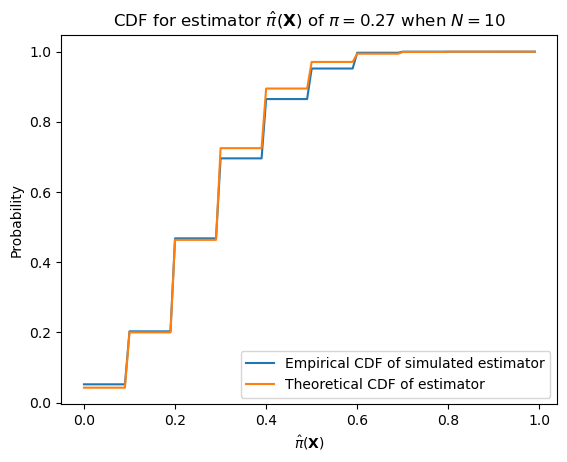

In [7]:
#| code-fold: true
#| code-summary: "Plotting code"

from numpy import round
from scipy.stats import binom

ax = subplot()
ax.plot(mgrid[0:n:0.1]/n, ecdf(mgrid[0:n:0.1]/n), label="Empirical CDF of simulated estimator")
ax.plot(mgrid[0:n:0.1]/n, binom(n, p).cdf(mgrid[0:n:0.1]), label="Theoretical CDF of estimator")

ax.legend()
ax.set_title(r"CDF for estimator $\hat{\pi}(\mathbf{X})$ of $\pi = "+ str(round(pi_hat, 2)) + "$ when $N=10$")
ax.set_xlabel(r"$\hat{\pi}(\mathbf{X})$")
_ = ax.set_ylabel("Probability")

With larger numbers of samples–e.g. the number of datapoints we have (12,279)–it will have much lower variance.

In [9]:
n = len(data)
p = pi_hat

samples = [sample_bernoulli_sample_mean(p, n) for _ in range(1000)]
ecdf = ECDF(samples)

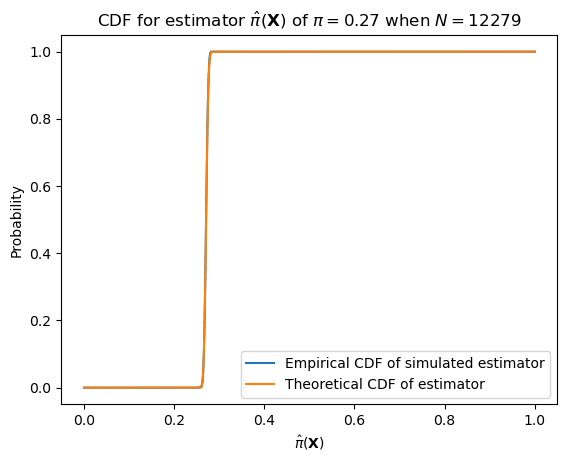

In [10]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()
ax.plot(mgrid[0:n:0.1]/n, ecdf(mgrid[0:n:0.1]/n), label="Empirical CDF of simulated estimator")
ax.plot(mgrid[0:n:0.1]/n, binom(n, p).cdf(mgrid[0:n:0.1]), label="Theoretical CDF of estimator")

ax.legend()
ax.set_title(r"CDF for estimator $\hat{\pi}(\mathbf{X})$ of $\pi = "+ str(round(pi_hat, 2)) + "$ when $N="+ str(len(data)) +"$")
ax.set_xlabel(r"$\hat{\pi}(\mathbf{X})$")
_ = ax.set_ylabel("Probability")

One such important distribution is that of the error.

$$e(\hat\pi(\mathbf{X})) = \hat\pi(\mathbf{X}) - \pi$$

We can describe this distribution as $N (\pi + e(\hat\pi(\mathbf{X}))) \sim \text{Binomial}(N, \pi)$.

In [11]:
def sample_bernoulli_sample_mean_error(p: float, n: int) -> float:
    return sample_bernoulli_sample_mean(p, n) - p

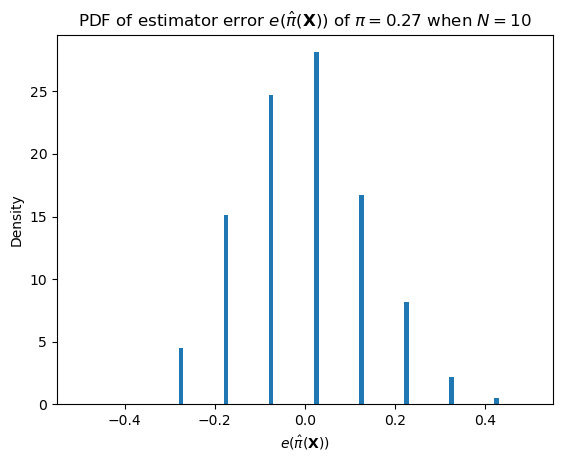

In [12]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

ax.hist([sample_bernoulli_sample_mean_error(pi_hat, 10) for _ in range(1000)], bins=100, range=[-0.5, 0.5], density=True)

ax.set_title(r"PDF of estimator error $e(\hat{\pi}(\mathbf{X}))$ of $\pi = "+ str(round(pi_hat, 2)) + "$ when $N=10$")
ax.set_xlabel(r"$e(\hat{\pi}(\mathbf{X}))$")
_ = ax.set_ylabel("Density")

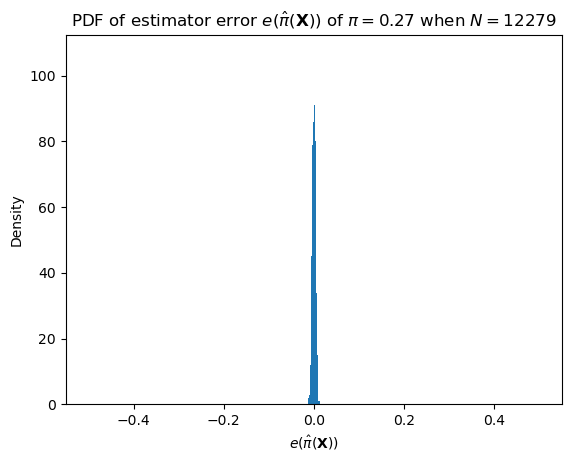

In [13]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

ax.hist([sample_bernoulli_sample_mean_error(pi_hat, len(data)) for _ in range(1000)], bins=1000, range=[-0.5, 0.5])

ax.set_title(r"PDF of estimator error $e(\hat{\pi}(\mathbf{X}))$ of $\pi = "+ str(round(pi_hat, 2)) + "$ when $N="+ str(len(data)) +"$")
ax.set_xlabel(r"$e(\hat{\pi}(\mathbf{X}))$")
_ = ax.set_ylabel("Density")

It also allows us to define two important quantities associated with the *estimator*: the *bias*, which is equivalent to the expected value of the error...

$$b(\hat\pi(\mathbf{X})) = \mathbb{E}[\hat\pi(\mathbf{X})] - \pi = \mathbb{E}[\hat\pi(\mathbf{X}) - \pi]$$

...and the *mean squared error* (MSE).

$$\text{MSE}(\hat\pi(\mathbf{X})) = \mathbb{E}\left[(\hat\pi(\mathbf{X}) - \pi)^2\right]$$

Both are ways of quantifying how off we will tend to be in estimating the parameter of interest at a particular sample size. So for instance, for the maximum likelihood estimator we've been looking at:

$$\text{b}(\hat\pi(\mathbf{X})) = \sum_{k=0}^N \left(\frac{k}{N} - \pi\right) \cdot {N \choose k}\pi^k(1-\pi)^{N-k}$$

$$\text{MSE}(\hat\pi(\mathbf{X})) = \sum_{k=0}^N \left(\frac{k}{N} - \pi\right)^2 \cdot {N \choose k}\pi^k(1-\pi)^{N-k}$$

Thus, while the bias of this estimator is 0, the MSE starts relatively high and goes down as $N \rightarrow \infty$, and it goes down faster the further from 0.5 $\pi$ is.

In [14]:
from numpy import arange, sum

def bernoulli_mle_mse(n, p):
  return sum((arange(n+1)/n - p)**2 * binom(n, p).pmf(arange(n+1)))

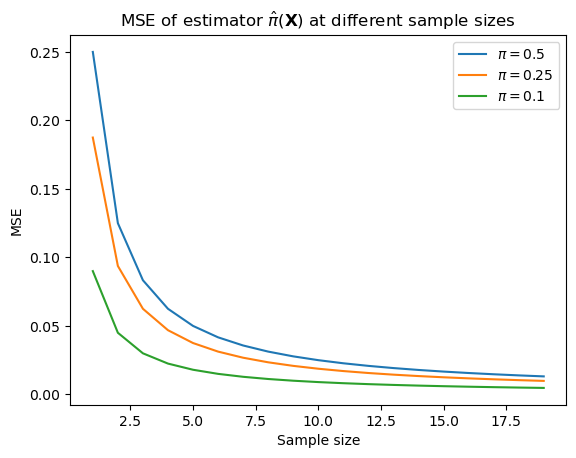

In [15]:
#| code-fold: true
#| code-summary: "Plotting code"

sample_sizes = arange(1, 20)

ax = subplot()

ax.plot(sample_sizes, [bernoulli_mle_mse(n, 0.5) for n in sample_sizes], label=r"$\pi = 0.5$")
ax.plot(sample_sizes, [bernoulli_mle_mse(n, 0.75) for n in sample_sizes], label=r"$\pi = 0.25$")
ax.plot(sample_sizes, [bernoulli_mle_mse(n, 0.9) for n in sample_sizes], label=r"$\pi = 0.1$")

ax.legend()

ax.set_title(r"MSE of estimator $\hat{\pi}(\mathbf{X})$ at different sample sizes")
ax.set_xlabel(r"Sample size")
_ = ax.set_ylabel("MSE")

We say that an estimator is unbiased if the bias of the estimator is $0$; otherwise it's biased. Therefore, the maximum likelihood estimator for the Bernoulli parameter is unbiased: it's always $0$, regardless of the sample size. 

But maximum likelihood estimators for many other distributions are not. For instance, the maximum likelihood estimator $\hat\mu(\mathbf{X})$ for the mean $\mu$ of a univariate normal distribution is also the sample mean $\hat\mu(\mathbf{x}) = \frac{\sum_{i=1}^N x_i}{N}$, and this estimator is unbiased. In contrast, the maximum likelihood estimator $\hat\sigma^2(\mathbf{X})$ for the variance $\sigma^2$ is the sample variance $\hat\sigma^2(\mathbf{x}) = \frac{\sum_{i=1}^N \left(x_i - \hat\mu(\mathbf{x})\right)^2}{N}$, but this estimator is biased: $b\left(\hat\sigma^2(\mathbf{X})\right) = -\frac{\sigma^2}{N}$. That is, in expectation, it underestimates the true variance by $-\frac{\sigma^2}{N}$. (I won't work through why this is, but you can find a proof [here](https://proofwiki.org/wiki/Bias_of_Sample_Variance).) It's for this reason that you'll often see an alternative estimator of the variance used: $s^2(\mathbf{X}) = \frac{\sum_{i=1}^N \left(x_i - \hat\mu(\mathbf{x})\right)^2}{N-1}$. 

In general, we aren't going to worry too much about bias (indeed, in some sense, we're going to lean into biased estimators), but it is useful to know the above if you haven't seen it before.

## Bayesian Inference

The maximum likelihood estimate is what's known as a [point estimate](https://en.wikipedia.org/wiki/Point_estimation) because it's a single number that gives the "best" estimate for the parameter given a way of estimating that parameter, such as MLE. But often we want to know how much uncertainty we should have about that estimate. For instance, if I compute the maximum likelihood estimate on the basis of only a single sample, that estimate, which will be either $0$ or $1$, will probably be terrible, even though, as we just discussed, the estimator is unbiased: it's expected error is $0$. The MSE gives us some indication of how much to trust the estimate (less with smaller sample sizes and more with larger sample sizes), but it doesn't really tell us which other possible estimates might be reasonable values.

Before talking about how we deal with this issue in Bayesian inference, I first want to discuss one way that frequentist inference deals with uncertainty and that you might be familiar with: [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval). The main reason I want to discuss confidence intervals is because they are tricky: their interpretation seems a lot clearer than it actually is.

### Confidence Intervals

A confidence interval for some parameter $\pi$ at some confidence level $\gamma \in (0, 1)$ is an interval $(l(\mathbf{X}), u(\mathbf{X}))$ whose bounds are determined by a pair of random variables $l(\mathbf{X})$ and $u(\mathbf{X})$. In being random variables, we can compute probabilities of events defined in terms of them. The probability that is relevant in constructing a confidence interval is $\mathbb{P}\left(l(\mathbf{X}) < \theta < u(\mathbf{X})\right)$. To construct a confidence interval at level $\gamma$, we're going to find the values of $l(\mathbf{X})$ and $u(\mathbf{X})$ such that $\mathbb{P}\left(l(\mathbf{X}) < \theta < u(\mathbf{X})\right) = \gamma$. 

Often, this interval needs to be approximated; and even in the case of the Bernoulli parameter, there are a variety of ways of doing this approximation. One way to do it is using the [Clopper-Pearson method](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval), which computes the interval as:

$$l(\mathbf{x}) = \inf \left\{\theta \,\,{\Big |}\,\,\left[\sum_{k=\sum_{i=0}^N x_i}^N\operatorname {Bin} \left(k; N, \theta \right)\right]>{\frac {1 - \gamma }{2}}\right\}$$

$$u(\mathbf{x}) = \sup\left\{\theta \,\,{\Big |}\,\,\left[\sum_{k=0}^{\sum_{i=0}^N x_i}\operatorname {Bin} \left(k; N, \theta \right)\right]>{\frac {1 - \gamma }{2}}\right\}$$

In [16]:
from statsmodels.stats.proportion import proportion_confint

In [16]:
#| code-fold: true
#| code-summary: Estimate CI with Clopper-Pearson

count_n_obs = [
    (2, 10),
    (20, 100),
    (200, 1_000)
]

for count, n_obs in count_n_obs:
    ci = round(
        proportion_confint(
            count=count, nobs=n_obs, 
            method='beta'
        ), 2
    )

    print(f"successes = {count}\tobservations = {n_obs}\t95% CI={ci}")

successes = 2	observations = 10	95% CI=[0.03 0.56]
successes = 20	observations = 100	95% CI=[0.13 0.29]
successes = 200	observations = 1000	95% CI=[0.18 0.23]


Alternatively, we'll very frequently compute confidence intervals via nonparametric bootstraps. In the simplest form of a nonparametric bootstrap, we take a dataset and resample it *with* replacement many times, thereby simulating the experiment on the basis of the distribution of samples. On each resampling, we compute the statistic of interest. Then, we compute the $\frac{1-\gamma}{2}$ and $1-\frac{1-\gamma}{2}$ quantiles of the collection of statistics–i.e. the values $l$ and $u$ such that $\frac{1-\gamma}{2}$ of the statistics are less the $l$ and $\frac{1-\gamma}{2}$ are greater than $u$. 

In [17]:
from typing import Tuple, Iterable
from numpy import concatenate, zeros, ones, quantile
from numpy.random import choice

def bootstrap_mean(
    x: Iterable, gamma: float=0.95, 
    n_iter: int=10_000
) -> Tuple[float, Tuple[float, float]]:
    """Confidence interval of the mean using a non-parametric bootstrap
    
    Parameters
    ----------
    x
        The data whose mean CI we want to bootstrap
    gamma
        The confidence level
    n_iter
        The number of bootstrap iterates
        
    Returns
    -------
    est
        The estimate of the mean
    ci
        The confidence interval
    """
    alpha = 1 - gamma

    resampled = [choice(x, len(x)) for _ in range(n_iter)]
    means = [mean(resamp) for resamp in resampled]

    cilo, est, cihi = quantile(means, [alpha/2, 0.5, 1 - alpha/2])

    return est, (cilo, cihi)

In [17]:
#| code-fold: true
#| code-summary: Estimate CI with nonparametric bootstrap

for count, n_obs in count_n_obs:
    samples = concatenate([ones(count), zeros(n_obs-count)])
    est, ci = bootstrap_mean(samples)

    print(f"successes = {count}\tobservations = {n_obs}\testimate: {est}\t95% CI={ci}")

successes = 2	observations = 10	estimate: 0.2	95% CI=(0.0, 0.5)
successes = 20	observations = 100	estimate: 0.2	95% CI=(0.12, 0.28)
successes = 200	observations = 1000	estimate: 0.2	95% CI=(0.175, 0.225)


Why do I say the interpretation of these intervals is tricky? I say this because you might try to read $\theta$ in $\mathbb{P}\left(l(\mathbf{X}) < \theta < u(\mathbf{X})\right)$ as a random variable, but it's importantly not in this context: $\theta$ is some fixed value that we're trying to estimate. So what this probability is telling us is how likely it is that the true, fixed value $\theta$ falls within the interval we construct when observing $\mathbf{X}$ many, many times. That is, the random variables here are those in $\mathbf{X}$, not $\theta$.

### Posterior Distributions

The way Bayesian inference deals with this issue is instead calculating something a bit more intuitive: the conditional distribution of the parameter $p(\theta\mid \mathbf{x})$. This approach is very different than the one we just saw because it requires us to view the parameter as (the value of) a random variable $\Theta = \theta$. Generally, we don't have a good idea what that conditional distribution looks like, but we may have some reasonable guesses about what $p(\mathbf{x} \mid \theta)$ and $p(\theta)$ look like. In this case, we will often invoke Bayes' theorem to try to compute $p(\theta\mid \mathbf{x})$.

$$\begin{align*}p(\theta\mid \mathbf{x}) &= \frac{p(\mathbf{x} \mid \theta)p(\theta)}{p(\mathbf{x})} \\ &= \begin{cases}\frac{p(\mathbf{x} \mid \theta)p(\theta)}{\sum_{\theta'} p(\mathbf{x}, \theta')} & \text{if } \Theta \text{ is discrete} \\ \frac{p(\mathbf{x} \mid \theta)p(\theta)}{\int p(\mathbf{x}, \theta')\,\mathrm{d}\theta'} & \text{if } \Theta \text{ is continuous} \\ \end{cases}\\ &= \begin{cases}\frac{p(\mathbf{x} \mid \theta)p(\theta)}{\sum_{\theta'} p(\mathbf{x} \mid \theta')p(\theta')} & \text{if } \Theta \text{ is discrete} \\ \frac{p(\mathbf{x} \mid \theta)p(\theta)}{\int p(\mathbf{x} \mid \theta')p(\theta')\,\mathrm{d}\theta'} & \text{if } \Theta \text{ is continuous} \\ \end{cases}\\ \end{align*} $$ 

In this context, $p(\theta\mid \mathbf{x})$ is often termed the *posterior* (since it is the distribution of $\Theta$ *after* observing $\mathbf{X}$), $p(\theta)$ is often termed the *prior* (since it is the distribution of $\Theta$ before observing $\mathbf{X}$), and $p(\mathbf{x})$ is often termed the *evidence*. The name for $p(\mathbf{x} \mid \theta)$ is one we've seen before: the likelihood. This terminology is where the notation $\mathcal{L}(\theta \mid \mathbf{x})$ I mentioned earlier comes from. In Bayesian inference, $\mathcal{L}$ is often defined as:

$$\mathcal{L}(\theta \mid \mathbf{x}) = p(\mathbf{x} \mid \theta)$$

This notation, which contrasts with the notation I used earlier–$\mathcal{L}(\theta \mid \mathbf{x}) = p(\mathbf{x}; \theta)$–is intended to emphasize that both $\mathbf{X}$ *and* $\Theta$ are viewed as random variables.

Because we generally assume a situation where the value of $\mathbf{X} = \mathbf{x}$ is known (or at least observable in principle), so $p(\mathbf{x})$ (the evidence) is a constant: whatever the probability (or density) of the actual observation is. Indeed, it's specifically a normalizing constant, since it doesn't depend on $\theta$. So in a reasonable number of cases, we actually only care about the numerator (the product of the prior and the likelihood): we only care that $p(\theta \mid \mathbf{x})$ is proportional to $p(\mathbf{x} \mid \theta)p(\theta)$.^[If you're not familiar with this *direct proportionality* notation, $x \propto y$ just means that there is some non-zero constant $k$ such that $x = ky$.] ^[Note that this implies that $p(\theta \mid \mathbf{x}) \propto p(\theta, \mathbf{x})$.]

$$p(\theta \mid \mathbf{x}) \propto p(\mathbf{x} \mid \theta)p(\theta)$$

"Full" Bayesian inference will always use the posterior distribution in downstream inferences–as I discuss below. To simulate frequentist inference, however, we will sometimes derive point estimates from this distribution: often, a measure of the posterior's central tendency (mean, median, or mode) and/or the $(1-\alpha)$% [credible interval](https://en.wikipedia.org/wiki/Credible_interval). The latter can be defined multiple ways. If the variable is univariate and continuous (which is often the case when computing credible intervals), one way is to define it as the interval $(\theta_\text{min}, \theta_\text{max})$ s.t. $\mathbb{P}(\theta < \theta_\text{min} \mid \mathbf{x}) = \mathbb{P}(\theta > \theta_\text{max} \mid \mathbf{x}) = \frac{\alpha}{2}$.

### Conjugate Priors

If we were to pick two arbitrary distributions for the likelihood $p(\mathbf{x} \mid \theta)$ and the prior $p(\theta)$ with which to express the posterior distribution $p(\theta \mid \mathbf{x})$, the posterior will often still be difficult to compute. But there are specific cases where computing it gets easier if we are prudent in our choice of what form the likelihood and prior take. Specifically, when the prior is *conjugate* to the likelihood, the posterior is guaranteed to be in the same distributional family as the prior (usually with different parameters).

An example of this can be seen with the beta and Bernoulli distributions we've been working with. Suppose that:

$$\Pi \sim \text{Beta}(\alpha, \beta)$$

And suppose we wanted to compute the posterior density $p(\pi \mid x)$ when we've observed a single $X$. We don't know this density directly, but we do know $p(x \mid \pi) = \text{Bern}(x \mid \pi)$ and the $p(\pi) = \text{Beta}(\pi; \alpha, \beta)$.^[Note, again, the use of a pipe for the PMF of $X$ and a semicolon for the PDF of $\Pi$. This notation is used to denote that $\pi$ is the value of some random variable, whereas $\alpha$ and $\beta$ are given by some oracle--namely, us.]

Let's work through the full expression of Bayes' theorem.

$$p(\pi \mid x) = \frac{p(x \mid \pi)p(\pi)}{p(x)} = \frac{p(x \mid \pi)p(\pi)}{\int p(x \mid \pi')p(\pi') \, \mathrm{d}\pi'}$$

And let's first deal with that denominator.

$$\begin{align*}p(x) &= \int p(x \mid \pi)p(\pi) \, \mathrm{d}\pi \\ &= \int_0^1 \text{Bern}(x\mid \pi)\,\text{Beta}(\pi; \alpha, \beta)\,\mathrm{d}\pi\\
&= \int_0^1 \pi^x(1-\pi)^{1-x}\frac{\pi^{\alpha-1}(1-\pi)^{\beta-1}} {\mathrm{B}(\alpha,\beta)} \,\mathrm{d}\pi\\ &= \frac{1}{\mathrm{B}(\alpha,\beta)}\int_0^1 \pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1} \,\mathrm{d}\pi\end{align*}$$

This formula looks complex, but it turns out that we can use a straightforward trick to simplify it: because PDFs must always integrate to 1 over the range of the random variable by the assumption of unit measure, e.g.,...

$$\int_0^1 \text{Beta}(\pi; \alpha, \beta)\,\mathrm{d}\pi = \int_0^1 \frac{\pi^{\alpha-1}(1-\pi)^{\beta-1}} {\mathrm{B}(\alpha,\beta)}\,\mathrm{d}\pi = 1$$

...and because the normalizing constant can always be factored out of the integral, since it doesn't depend on the variable of integration, e.g., ... 

$$\int_0^1 \frac{\pi^{\alpha-1}(1-\pi)^{\beta-1}} {\mathrm{B}(\alpha,\beta)}\,\mathrm{d}\pi = \frac{1} {\mathrm{B}(\alpha,\beta)}\int_0^1 \pi^{\alpha-1}(1-\pi)^{\beta-1}\,\mathrm{d}\pi$$

...it must be that the *unnormalized PDF*, e.g., $\pi^{\alpha-1}(1-\pi)^{\beta-1}$ integrates to the normalizing constant:

$$\int_0^1 \pi^{\alpha-1}(1-\pi)^{\beta-1}\,\mathrm{d}\pi = \mathrm{B}(\alpha,\beta)$$

Why does this help us? Well. We can view the value we need to integrate in our compound distribution as an unnormalized PDF of a random variable $\text{Beta}(\alpha + x, \beta + (1-x))$ and thus: 

$$\begin{align*}p(x) &= \frac{1}{\mathrm{B}(\alpha,\beta)}\int_0^1 \pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1} \,\mathrm{d}\pi\\ &= \frac{\mathrm{B}(\alpha + x, \beta + (1-x))}{\mathrm{B}(\alpha,\beta)} \end{align*}$$

This still looks complex, but it's actually not, because we can take advantage of the properties of the gamma function.

$$\begin{align*}p(x) &= \frac{\mathrm{B}(\alpha + x, \beta + (1-x))}{\mathrm{B}(\alpha,\beta)}\\ &= \frac{\left(\frac {\Gamma (\alpha+x)\Gamma (\beta+(1-x))}{\Gamma (\alpha+\beta+1)}\right)}{\left(\frac {\Gamma (\alpha)\Gamma (\beta)}{\Gamma (\alpha+\beta)}\right)} \\ &= \frac{\Gamma (\alpha+\beta)}{\Gamma (\alpha+\beta+1)} \frac{\Gamma (\alpha+x)}{\Gamma (\alpha)} \frac{\Gamma (\beta+(1-x))}{\Gamma (\beta)} \\ &= \begin{cases}\frac{\alpha}{\alpha+\beta} & \text{if } x = 1\\ \frac{\beta}{\alpha+\beta} & \text{if } x = 0\end{cases} \\ &= \left(\frac{\alpha}{\alpha+\beta}\right)^x\left(1-\frac{\alpha}{\alpha+\beta}\right)^{1-x} \end{align*}$$

$X$ (in contrast to $X \mid \Pi$, which is distributed Bernoulli) is thus said to be distributed $\text{BetaBernoulli}(\alpha, \beta)$, which as we just showed turns out to be equivalent to being distributed $\text{Bernoulli}\left(\frac{\alpha}{\alpha+\beta}\right)$. The BetaBernoulli distribution is our first instance of a [compound probability distribution](https://en.wikipedia.org/wiki/Compound_probability_distribution). We'll see more such distributions throughout the course.^[Indeed, we've already seen another: it turns out that the negative binomial distribution [can be viewed](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Gamma%E2%80%93Poisson_mixture) as a compound probability distribution.]

So now we know what the denominator looks like; what's the numerator? Well. We've already computed it while computing the denominator: 

$$p(x \mid \pi)p(\pi) = \frac{\pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1}}{\mathrm{B}(\alpha, \beta)}$$

Thus:

$$p(\pi \mid x) = \frac{\left(\frac{\pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1}}{\mathrm{B}(\alpha, \beta)}\right)}{\left(\frac{\alpha}{\alpha+\beta}\right)^x\left(\frac{\beta}{\alpha+\beta}\right)^{1-x}}$$

I promised a form for the posterior that was in the same family as the prior, so this should be a beta distribution; but it doesn't really look like one. It is, though; and to see it, we need to go back to:

$$p(x) = \frac{\mathrm{B}(\alpha + x, \beta + (1-x))}{\mathrm{B}(\alpha,\beta)}$$

Using this equality, we get: 

$$\begin{align*}p(\pi \mid x) &= \frac{\left(\frac{\pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1}}{\mathrm{B}(\alpha, \beta)}\right)}{\left(\frac{\mathrm{B}(\alpha + x, \beta + (1-x))}{\mathrm{B}(\alpha,\beta)}\right)}\\ &= \frac{\pi^{x+\alpha-1}(1-\pi)^{\beta+(1-x)-1}}{\mathrm{B}(\alpha + x, \beta + (1-x))}\\ &= \mathrm{Beta}(\pi \mid \alpha + x, \beta + (1-x))\\ \end{align*}$$

Intuitively, this can be read: "if I started out believing that $\Pi$ was distributed $\text{Beta}(\alpha, \beta)$ and then I observed that $X = x$, I now should believe that $\Pi$ is distributed $\mathrm{Beta}(\pi \mid \alpha + x, \beta + (1-x))$."

So if I started out with a uniform distribution on $\pi \sim \text{Beta}(1, 1)$...

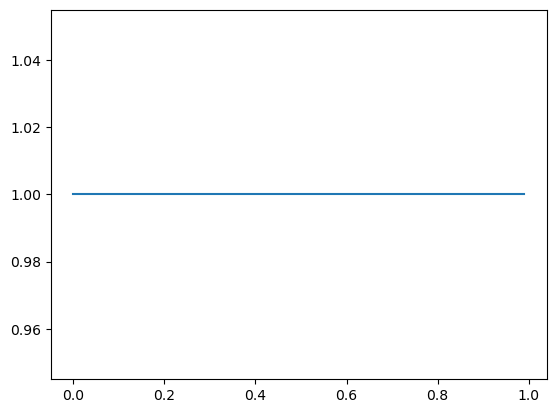

In [18]:
#| code-fold: true
#| code-summary: "Plotting code"

from scipy.stats import beta

ax = subplot()

_ = ax.plot(mgrid[0:1:0.01], beta(1, 1).pdf(mgrid[0:1:0.01]))

...and I observed $X = 1$, I shift the density to the right: $\pi \mid X = 1 \sim \text{Beta}(2, 1)$...

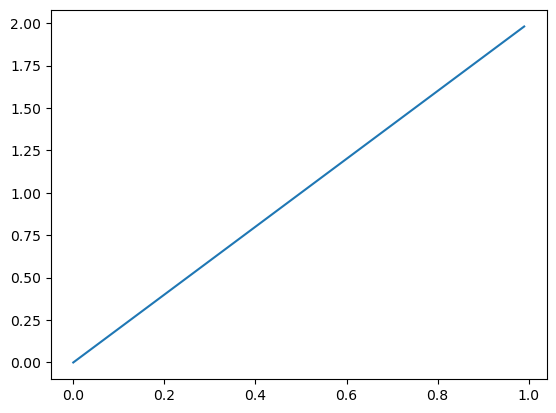

In [19]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

_ = ax.plot(mgrid[0:1:0.01], beta(2, 1).pdf(mgrid[0:1:0.01]))

...but if I observed $X = 0$, I shift the density to the left: $\pi \mid X = 0 \sim \text{Beta}(1, 2)$.

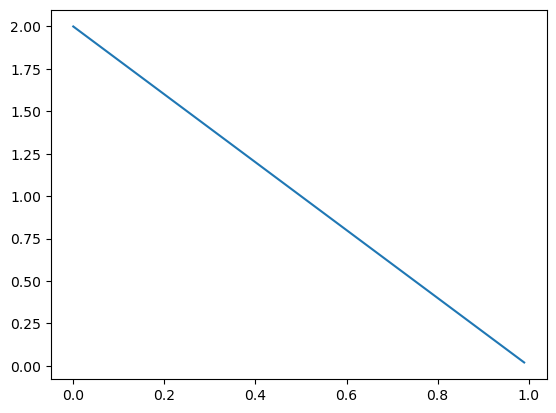

In [20]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

_ = ax.plot(mgrid[0:1:0.01], beta(1, 2).pdf(mgrid[0:1:0.01]))

If I start out with a much denser prior, like $\pi \sim \text{Beta}(10, 10)$...

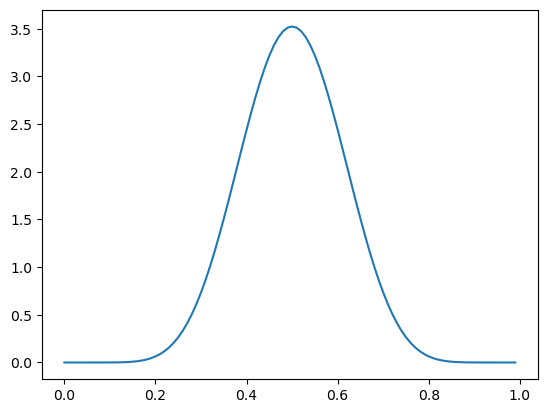

In [21]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

_ = ax.plot(mgrid[0:1:0.01], beta(10, 10).pdf(mgrid[0:1:0.01]))

... the shifts to $\pi \mid X = 1 \sim \text{Beta}(11, 10)$ and $\pi \mid X = 0 \sim \text{Beta}(10, 11)$ are much smaller.

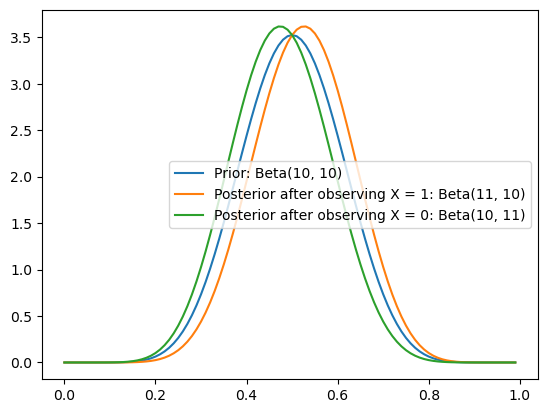

In [22]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

ax.plot(mgrid[0:1:0.01], beta(10, 10).pdf(mgrid[0:1:0.01]), label="Prior: Beta(10, 10)")
ax.plot(mgrid[0:1:0.01], beta(11, 10).pdf(mgrid[0:1:0.01]), label="Posterior after observing X = 1: Beta(11, 10)")
ax.plot(mgrid[0:1:0.01], beta(10, 11).pdf(mgrid[0:1:0.01]), label="Posterior after observing X = 0: Beta(10, 11)")

_ = ax.legend()

So the stronger I believe something initially (e.g. that there is high density nearest to $0.5$), the less I can be swayed one way or another by a single piece of evidence.

#### Predictive Distributions

We'll use conjugacy extensively throughout this course. To give you a taste: one important place it will show up is in the context of making predictions about what we will see in the future ($x_\text{new}$) based on what we've already seen ($\mathbf{x}_\text{old}$), which we can formulate using what's know as the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution).

$$\begin{align*}p(x_\text{new} \mid \mathbf{x}_\text{old}) &= \int p(x_\text{new}, \pi \mid \mathbf{x}_\text{old})\,\mathrm{d}\pi & \text{definition of joint distribution}\\ &= \int p(x_\text{new}\mid \pi; \mathbf{x}_\text{old})p(\pi \mid \mathbf{x}_\text{old})\,\mathrm{d}\pi & \text{definition of conditional probability}\\ &= \int p(x_\text{new}\mid \pi)p(\pi \mid \mathbf{x}_\text{old})\,\mathrm{d}\pi & \text{conditional independence assumption}\\ &= \int \mathcal{L}(\pi \mid x_\text{new})p(\pi \mid \mathbf{x}_\text{old})\,\mathrm{d}\pi  & \text{definition of $\mathcal{L}$}\\ &= \mathbb{E}\left[\mathcal{L}(\Pi \mid x_\text{new})\mid \mathbf{X}\right] & \text{definition of conditional expectation}\\\end{align*}$$

In the context of our running example, this can be read "if I've observed vowels with heights $\mathbf{x}_\text{old}$, the probability that the next vowel I observe $x_\text{new}$ will be high can be found by taking the conditional expectation of the likelihood $\mathcal{L}(\Pi \mid x_\text{new})$ (a function of the random variable $\Pi$) given $\mathbf{X}_\text{old}$." 

We know by slightly extending what we saw above that:

$$p(\pi \mid \mathbf{x}; \alpha, \beta) = \text{Beta}\left(\pi; \alpha + \sum_i x_{\text{old}, i}, \beta + \sum_i 1 - x_{\text{old}, i}\right)$$

And since $p(x_\text{new}\mid \pi) = \text{Bernoulli}(x_\text{new}; \pi)$ by the work we did to prove the beta-Bernoulli conjugacy, we know that: 

$$p(x_\text{new}\mid \pi; \mathbf{x}_\text{old})p(\pi \mid \mathbf{x}_\text{old}) = \frac{\pi^{\alpha + x_\text{new} + \sum_i x_{\text{old}, i} - 1}(1-\pi)^{\beta + (1-x_\text{new}) +\sum_i 1 - x_{\text{old}, i}-1}}{\mathrm{B}\left(\alpha + \sum_i x_{\text{old}, i}, \beta  +\sum_i 1 - x_{\text{old}, i}\right)}$$

So:

$$\begin{align*}p(x_\text{new} \mid \mathbf{x}_\text{old}) &= \int \frac{\pi^{\alpha + x_\text{new} + \sum_i x_{\text{old}, i} - 1}(1-\pi)^{\beta + (1-x_\text{new}) +\sum_i 1 - x_{\text{old}, i}-1}}{\mathrm{B}\left(\alpha + \sum_i x_{\text{old}, i}, \beta  +\sum_i 1 - x_{\text{old}, i}\right)}\,\mathrm{d}\pi\\ &= \frac{\int \pi^{\alpha + x_\text{new} + \sum_i x_{\text{old}, i} - 1}(1-\pi)^{\beta + (1-x_\text{new}) +\sum_i 1 - x_{\text{old}, i}-1} \,\mathrm{d}\pi}{\mathrm{B}\left(\alpha + \sum_i x_{\text{old}, i}, \beta  +\sum_i 1 - x_{\text{old}, i}\right)}\\ &= \frac{\mathrm{B}\left(\alpha + x_\text{new} + \sum_i x_{\text{old}, i}, \beta + (1-x_\text{new}) +\sum_i 1 - x_{\text{old}, i}\right)}{\mathrm{B}\left(\alpha + \sum_i x_{\text{old}, i}, \beta  +\sum_i 1 - x_{\text{old}, i}\right)}\\\end{align*}$$

This form is exactly like what we had when computing the computing $p(x)$, and the same logic for reducing it can be deployed here.

$$p(x_\text{new} \mid \mathbf{x}_\text{old}) = \text{BetaBern}\left(x_\text{new}; \alpha + \sum_i x_{\text{old}, i}, \beta + \sum_i 1- x_{\text{old}, i}\right) = \text{Bern}\left(x_\text{new}; \frac{\alpha + \sum_i x_{\text{old}, i}}{\alpha + \beta + N}\right)$$

This is of course not a coincidence: the evidence $p(x) = \int p(x\mid \pi)p(\pi)\,\mathrm{d}\pi$ is always the *prior predictive distribution*, which is just like the posterior predictive distribution, but without the conditioning on prior data.

$$p(x) = \mathbb{E}\left[\mathcal{L}(\Pi \mid x)\right]$$

### Beyond conjugacy

It is often the case that we cannot derive the posterior $p(\theta \mid \mathbf{x})$ analytically–i.e. without any integrals, as we did above. For instance, suppose we wanted to compute the evidence/prior predictive $p(\mathbf{x})$ from our example above, but instead of assuming that the prior $p(\pi)$ was beta-distributed, we wanted to assume it was distributed [logit-normal](https://en.wikipedia.org/wiki/Logit-normal_distribution). 

$$p(\pi; \mu, \sigma) \propto \frac{\exp\left(-\frac  {(\text{logit}(\pi)-\mu )^2}{2\sigma^2}\right)}{\pi(1-\pi)}$$

In [23]:
from numpy import inf
from scipy.stats import rv_continuous, norm
from scipy.special import logit, expit

class logitnorm_gen(rv_continuous):
    """A logit-normal generator
    
    See https://stackoverflow.com/a/73084994
    """
    
    def _argcheck(self, m, s):
        return (s > 0.) & (m > -inf)
    
    def _pdf(self, x, m, s):
        return norm(loc=m, scale=s).pdf(logit(x))/(x*(1-x))
    
    def _cdf(self, x, m, s):
        return norm(loc=m, scale=s).cdf(logit(x))
    
    def _rvs(self, m, s, size=None, random_state=None):
        return expit(m + s*random_state.standard_normal(size))
    
    def fit(self, data, **kwargs):
        return norm.fit(logit(data), **kwargs)

logitnorm = logitnorm_gen(a=0.0, b=1.0, name="logitnorm")

The logit-normal can capture many beta-like shapes, including both sparse and dense distributions and unimodal and bimodal distributions.

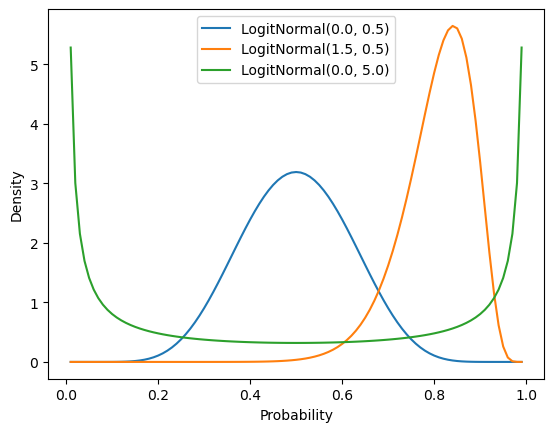

In [24]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

probability = mgrid[0.01:1.0:0.01]

mu_sigma = [
    (0.0, 0.5),
    (1.5, 0.5),
    (0.0, 5.0)
]

for mu, sigma in mu_sigma:
    ax.plot(
        probability, 
        logitnorm(mu, sigma).pdf(probability),
        label=f"LogitNormal({mu}, {sigma})"
    )
    
ax.legend()

ax.set_xlabel("Probability")
_ = ax.set_ylabel("Density")

In this case, we won't be able to map this to a known distribution. We need to resort to approximating it.

$$\begin{align*}
p(\mathbf{x}) &= \int p(\mathbf{x} \mid \pi)p(\pi; \mu, \sigma)\,\mathrm{d}\pi\\
&\propto \int \pi^{\sum_i x_i}(1-\pi)^{\sum_i (1-x_i) }\frac{\exp\left(-\frac  {(\text{logit}(\pi)-\mu )^2}{2\sigma^2}\right)}{\pi(1-\pi)}\,\mathrm{d}\pi\\
&\propto \int \pi^{\sum_i x_i - 1}(1-\pi)^{\sum_i (1-x_i) - 1}\exp\left(-\frac  {(\text{logit}(\pi)-\mu )^2}{2\sigma^2}\right)\,\mathrm{d}\pi\\
\end{align*}$$

#### Monte Carlo Integration

One way to do this is by brute force using some form of [numerical integration](https://en.wikipedia.org/wiki/Numerical_integration)–e.g. a [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration) technique. In this case, we sample many (say, $K$) values $\pi_k$ from the logit-normal prior (which, I will assert, we know how to sample from), evaluate the likelihood under $\pi_k$, then average those likelihoods.

$$p(\mathbf{x}) \approx \frac{1}{K}\sum_{k=1}^K p(\mathbf{x} \mid \pi_k) = \frac{1}{K}\sum_{k=1}^N \pi_k^{\sum_i x_i}(1-\pi_k)^{\sum_i (1-x_i) }$$

In [25]:
from numpy import ndarray, log
from scipy.special import logsumexp
from scipy.stats import bernoulli

def bernoulli_logit_normal_log_evidence(x: ndarray, mu: float, sigma: float, n_approx: int=1_000) -> float:
    """The log-evidence of the data under a Bernoulli likelihood with logit-normal prior
    
    Parameters
    ----------
    x
        The data
    mu
        The mean log-odds for the logit-normal
    sigma
        The standard deviation in the log-odds for the logit-normal
    n_approx
        The number of samples to draw in approximating the evidence
    """
    n, = x.shape
    
    return logsumexp([
        bernoulli(pi_bar_k).logpmf(x).sum()
        for pi_bar_k in logitnorm(mu, sigma).rvs(n_approx)
    ]) - log(n_approx)

Keeping the number of observations $N$ fixed, we can then plot the approximate log-evidence in terms of the proportion of true observations for different settings of the logit-normal parameters ($\mu$ and $\sigma$).^[Note that each proportion $p \in \left\{\frac{1}{N}, \frac{2}{N}, \ldots, 1\right\}$ corresponds to ${N \choose pN}$ possible $\mathbf{x}$s but that the log-evidence must be the same for each such $\mathbf{x}$ if the likelihood is Bernoulli.]

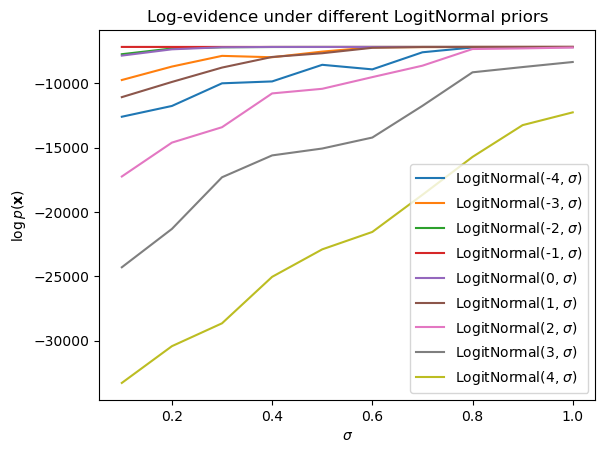

In [26]:
#| code-fold: true
#| code-summary: "Plotting code"

from numpy.random import seed

seed(4329)

ax = subplot()

mus = arange(-4, 5)
sigmas = mgrid[0.1:1.1:0.1]

for mu in mus:
    log_evidence = [
        bernoulli_logit_normal_log_evidence(data, mu, sigma)
        for sigma in sigmas
    ]
    ax.plot(sigmas, log_evidence, label=f"LogitNormal({mu}, "+ r"$\sigma$)")

ax.legend()

ax.set_title("Log-evidence under different LogitNormal priors")
ax.set_xlabel(r"$\sigma$")
_ = ax.set_ylabel(r"$\log p(\mathbf{x})$")

This approach works because we can sample $\pi_k$ from the prior. But it becomes hairy in the case where we don't know how to draw such samples. For instance, suppose we want to compute the posterior predictive $p(x_\text{new} \mid \mathbf{x}_\text{old})$. 

$$p(x_\text{new} \mid \mathbf{x}_\text{old}) = \int p(x_\text{new}  \mid \pi)p(\pi \mid \mathbf{x}_\text{old})\,\mathrm{d}\pi$$

In this case, we need to be able to sample from the posterior $p(\pi \mid \mathbf{x}_\text{old})$. But we don't know how to sample from the posterior because, as we just saw, it doesn't have a known distribution. One idea–the core idea of [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling)–is to sample candidate $\pi'_k$s from some *proposal distribution* $q(\pi')$ that we know how to sample from (e.g. in this case, the uniform is a reasonable choice) and then weight the average we aim to compute in the appropriate way. To see why this works, note that we can rewrite $p(x_\text{new} \mid \mathbf{x}_\text{old})$ as an expectation of $\Pi' \sim q(\cdot)$. 

$$\begin{align*}
p(x_\text{new} \mid \mathbf{x}_\text{old}) &= \int p(\mathbf{x} \mid \pi)p(\pi \mid \mathbf{x})\,\mathrm{d}\pi\\
&= \int p(\mathbf{x} \mid \pi)p(\pi \mid \mathbf{x})\frac{q(\pi)}{q(\pi)}\,\mathrm{d}\pi\\
&= \int p(\mathbf{x} \mid \pi')\frac{p(\pi' \mid \mathbf{x})}{q(\pi')}q(\pi')\,\mathrm{d}\pi'\\
&= \mathbb{E}\left[p(\mathbf{x} \mid \Pi')\frac{p(\Pi' \mid \mathbf{x})}{q(\Pi')}\right]
\end{align*}$$

This rewrite then allows us to sample from the proposal distribution–rather than the actual distribution–in approximating $p(x_\text{new} \mid \mathbf{x}_\text{old})$ using Monte Carlo integration. We merely need to reweight the sample by $\frac{p(\pi \mid \mathbf{x})}{q(\pi)}$ to account for the fact that we are sampling from a different distribution.^[To develop additional intuition for why this reweighting is necessary: consider a very simple case where we are trying to approximate the expectation $\mathbb{E}[U] = \int u\,p(u)\,\mathrm{d}u$ of a uniform random variable $U \sim \mathcal{U}(0, 1)$ with importance sampling. (We would never do this–not least because we can easily compute the expected value analytically–but it is useful for illustrating the point.) And suppose we chose as our proposal distribution $U'_k \sim \text{Beta}(2, 1)$. If we didn't reweight by $\frac{\mathcal{U}(u'_k; 0, 1)}{\text{Beta}(u'_k; 2, 1)} = \frac{1}{\text{Beta}(u'_k; 2, 1)}$, we'd end with the expectation of $U'_k$, which is $\frac{2}{3}$, not $U$, which is $\frac{1}{2}$!] 

$$p(x_\text{new} \mid \mathbf{x}_\text{old}) \approx \frac{1}{K}\sum_{k=1}^K p(x_\text{new} \mid \pi'_k)\frac{p(\pi'_k \mid \mathbf{x}_\text{old})}{q(\pi'_k)}$$

Now, one thing you might have noticed is that we actually have to approximate two integrals to compute $p(x_\text{new} \mid \mathbf{x}_\text{old})$: (i) the integral over the posterior we just handled; and (ii) the integral over the prior, which is implicit in the denominator of the posterior–the evidence $p(\mathbf{x})$ in $p(\pi \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid \pi)p(\pi)}{p(\mathbf{x})}$. In principle, because the $p(\mathbf{x})$ is a constant relative to the first integral, we can pull it out and just compute it once.

$$p(x_\text{new} \mid \mathbf{x}_\text{old}) \approx \frac{1}{Kp(\mathbf{x})}\sum_{k=1}^N p(x_\text{new} \mid \pi'_k)\frac{p(\mathbf{x}_\text{old}\mid\pi'_k)p(\pi'_k)}{q(\pi'_k)}$$

But since we don't really care about it in the context of computing $p(x_\text{new} \mid \mathbf{x}_\text{old})$, it would be nice if we could ignore it altogether. One way to do this is to take a different approach to sampling that attempts to actually produce a set of samples from the posterior, rather than drawing samples from some other distribution and subsequently reweighting them (as in importance sampling).

#### Markov Chain Monte Carlo

[Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) methods attempt to sample from the posterior directly. The idea behind MCMC is to start from some sample $\theta$ and then *propose* a new sample $\theta'$ conditioned on $\theta$ that we *accept* or *reject* based on how (i) probable that sample is under the distribution we are attempting to sample from; and (ii) how probable the previous sample was under the distribution we are attempting to sample from. If we accept the proposal, we log it and use it to condition the proposal of the new sample; otherwise, we try again using $\theta$ to condition the new proposal. Together, the sequence of $\theta$s is our sample from the posterior.

MCMC still requires us to evaluate the distribution of interest at each sample; but because it relies on comparison of the probabilities of the current sample and the proposal, the constant terms in that comparison cancel each other out–meaning we don't need to worry about computing quantities, like the evidence $p(\mathbf{x})$, that we're not interested in.   

##### Metropolis-Hastings samplers

One simple family of methods that can be useful in getting an intuition for how MCMC work are those that use the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) (MH). I'll walk through how an MH sampler can be built for the example above; but know that, for the remainder of the course, we will use [STAN](https://mc-stan.org/) to automatically construct and deploy samplers that use [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo), which has various benefits over simpler approaches but which is somewhat different from the simple MH algorithm I'll present here.

Similar to importance sampling, the basic idea behind the MH algorithm is to define some proposal distribution $q(\theta' \mid \theta)$ for generating proposals. Unlike in importance sampling, this distribution is generally conditioned on the previous sample $\theta_{k-1}$. We start the sampler by choosing some initial sample $\theta_0$. Then, for each sample $k$ we'd like to draw we:

1. Sample a candidate $\theta'_k \sim q(\cdot \mid \theta_{k-1})$
2. Calculate the *acceptance ratio* $\alpha_k = \frac{p(\theta'_k \mid \mathbf{x})q(\theta'_k \mid \theta_{k-1})}{p(\theta_{k-1} \mid \mathbf{x})q(\theta_{k-1} \mid \theta'_k)}$
3. Sample whether to accept the proposal $a_k \sim \text{Bernoulli}(\min(\alpha_k, 1))$
4. If $a_k$, set $\theta_k = \theta'_k$; otherwise $\theta_k = \theta_{k-1}$

In the case of our Bernoulli-logit normal model, we could define a relatively simple proposal distribution $\mathcal{U}(l_k, u_k)$, where $l_k \equiv \max\left(0, \theta_{k-1} - \frac{\delta}{2}\right)$, $u_k \equiv \min\left(1, \theta_{k-1} + \frac{\delta}{2}\right)$, and $\delta$ is a parameter of the sampler. This proposal distribution ensures that the proposal $\pi'_k \in [0, 1]$ and that we only ever propose samples at most $\frac{\delta}{2}$ from $\pi_{k-1}$.^[Another good alternative would be a $\text{LogitNormal}\left(\text{logit}^{-1}(\pi_{k-1}), \sigma\right)$, where $\sigma$ is analogous to $\delta$ above, or a $\text{Beta}(\nu\pi_{k-1}, \nu(1-\pi_{k-1}))$, where $\nu$ is (inversely) analogous to $\delta$.]

In [55]:
from numpy import array, exp, corrcoef
from scipy.stats import uniform

class BernoulliLogitNormalPosteriorMHSampler:
    """A Metropolis-Hastings sampler for a Bernoulli-LogitNormal model
    
    Parameters
    ----------
    mu
        mean log-odds for LogitNormal
    sigma
        standard deviation for LogitNormal
    """
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
        
    def _initialize(self, x: ndarray, n_samples: int, delta: float):
        # save the data `x` and sampler parameter `delta`
        self.x = x
        self.delta = delta
        
        # initialize the samples to -inf so it is easier to detect bugs
        # in the sampler implementation
        self.samples = zeros(n_samples) - inf
        
        # set the initial sample to the mean of the data (the MLE)
        self.sample[0] = x.mean()
        
        # initialize the log unnormalized posterior for the samples 
        # to -inf
        self.lup = zeros(n_samples) - inf
        
        # set the initial log unnormalized posterior to the log 
        # unnormalized posterior for the initial sample
        self.lup[0] = self._log_unnormalized_posterior(self.samples[0])
    
    def fit(self, x: ndarray, n_samples: int = 20_000, delta: float = 0.1, 
            burnin: int = 2_000, thinning: int = 100, 
            verbosity: int = 0) -> 'BernoulliLogitNormalPosteriorMHSampler':
        self._initialize(x, n_samples, delta)
        
        acceptance_count = 0
        
        for k in range(1, n_samples):
            # sample proposal
            pi_prime_k = self._propose(k)
            
            # log transition probabilities
            ltp_f, ltp_b = self._log_transition_prob(pi_prime_k, k)
            
            # log unnormalized posterior for pi_prime_k
            lup = self._log_unnormalized_posterior(pi_prime_k)
            
            # log acceptance ratio
            lar = (lup + ltp_f) - (self.lup[k-1] + ltp_b)
            
            # acceptance probability
            ap = min(exp(lar), 1)
            
            # sample whether to accept
            accept, = bernoulli(ap).rvs(1)
            
            # save sample
            if accept:
                self.samples[k] = pi_prime_k
                self.lup[k] = lup
                
                acceptance_count += 1
                
            else:
                self.samples[k] = self.samples[k-1]
                self.lup[k] = self.lup[k-1]

            if verbosity and k and not (k % verbosity):
                print(f"Sample {k}")
                print(f"Acceptance proportion: {round(acceptance_count / k, 2)}")
                print(f"Sample:                {round(self.samples[k], 2)}")
                print()
                
        # throw out burn-in samples and thin samples
        self.samples = self.samples[burnin::thinning]
                
        if verbosity:
            autocorrelation = corrcoef(self.samples[:-1], self.samples[1:])[1,0]
            print(f"Autocorrelation: {autocorrelation}")
            print()
                
        return self
            
    def _propose(self, k: int) -> float:
        l, u = self._proposal_bounds(
            self.samples[k-1], self.delta
        )
        
        # uniform parameterized by (loc, loc + scale)
        pi_prime_k, = uniform(l, u - l).rvs(1)
        
        return pi_prime_k
    
    def _log_transition_prob(self, pi_prime_k: float, k: int) -> float:
        # forward proposal bounds
        l_f, u_f = self._proposal_bounds(
            self.samples[k-1], self.delta
        )
        
        # forward log transition probability
        ltp_f = uniform(l_f, u_f - l_f).logpdf(pi_prime_k)
        
        # backward proposal bounds
        l_b, u_b = self._proposal_bounds(
            pi_prime_k, self.delta
        )
        
        # backward log transition probability
        ltp_b = uniform(l_b, u_b - l_b).logpdf(self.samples[k-1])
        
        return ltp_f, ltp_b
        
    def _log_unnormalized_posterior(self, pi: float):
        log_likelihood = bernoulli(pi).logpmf(self.x).sum()
        log_prior = logitnorm(self.mu, self.sigma).logpdf(pi)
        
        return log_likelihood + log_prior
    
    def _proposal_bounds(self, pi: float, delta: float) -> Tuple[float]:
        d = delta/2
        a, b = pi + array([-d, d])
        
        return max(a, 0), min(b, 1)

We'll fit this using a $\text{LogitNormal}(0, 1)$ prior.^[In light of the amount of data we have, the prior is not going to matter very much.]

In [28]:
seed(302928)

mh_sampler = BernoulliLogitNormalPosteriorMHSampler(0., 1.)

For comparison, a $\text{LogitNormal}(0, 1)$ prior has a relatively similar shape to a $\text{Beta}(2, 2)$ prior.

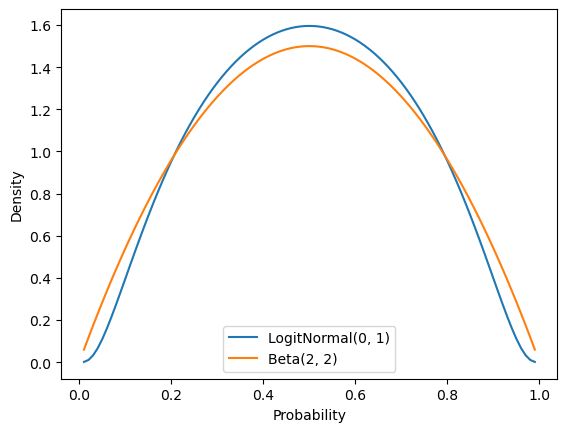

In [29]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

probability = mgrid[0.01:1.0:0.01]

ax.plot(
    probability, 
    logitnorm(0, 1).pdf(probability),
    label=f"LogitNormal(0, 1)"
)

ax.plot(
    probability, 
    beta(2, 2).pdf(probability),
    label=f"Beta(2, 2)"
)
    
ax.legend()

ax.set_xlabel("Probability")
_ = ax.set_ylabel("Density")

If we run this sampler and then plot the posterior samples, we get an approximation to the posterior distribution that is very close to the analytically computable posterior distribution under the assumption that the prior is distributed beta.

In [30]:
_ = mh_sampler.fit(data, delta=0.01)

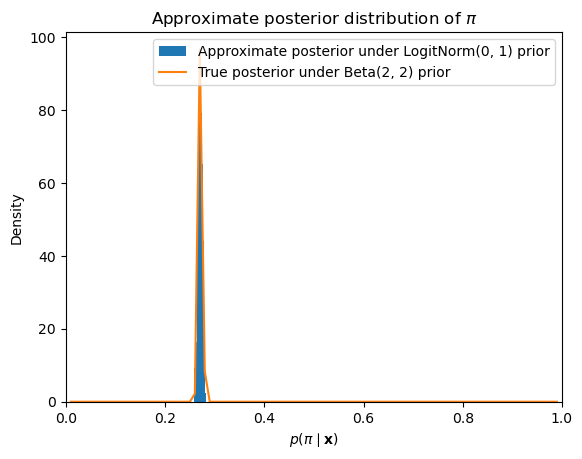

In [31]:
#| code-fold: true
#| code-summary: "Plotting code"

ax = subplot()

ax.set_xlim(0, 1)

ax.hist(mh_sampler.samples, bins=10, density=True, label="Approximate posterior under LogitNorm(0, 1) prior")
ax.plot(
    mgrid[0.01:1.0:0.01], 
    beta(
        2 + data.sum(), 
        2 + (1-data).sum()).pdf(mgrid[0.01:1.0:0.01]
    ), 
    label="True posterior under Beta(2, 2) prior"
)

ax.legend()

ax.set_title(r"Approximate posterior distribution of $\pi$")
ax.set_xlabel(r"$p(\pi \mid \mathbf{x})$")
_ = ax.set_ylabel("Density")

##### Implementing samplers in STAN

It is quite rare to implement MCMC samplers by hand nowadays. In general, we would rather use some software package that allows us to specify our desired distributional assumptions and then builds a sampler programmatically based on those assumptions. [STAN](https://mc-stan.org/), which is the package we will use, is a popular choice for doing this. Other packages for doing this in python are [`pymc`](https://www.pymc.io/) and [`pyro`](https://pyro.ai/).

The way we construct a model in STAN is by declaring the form of the data (including both the data we are modeling and any parameters of the priors) and the distributional assumptions that make up the model. These are specified in [program blocks](https://mc-stan.org/docs/2_18/reference-manual/overview-of-stans-program-blocks.html). 

The [`data` block](https://mc-stan.org/docs/2_18/reference-manual/program-block-data.html) specifies what the inputs STAN can expect to receive look like. 

```{.stan include="bernoulli-logit-normal-model.stan" start-line=1 end-line=6}
```

The [`parameters` block](https://mc-stan.org/docs/2_18/reference-manual/program-block-parameters.html) specifies which parameters STAN will need to sample.

```{.stan include="bernoulli-logit-normal-model.stan" start-line=8 end-line=10}
```

In our case, we are specifying an *auxiliary variable* `logodds` that corresponds to $\text{logit}(\pi) = \log\frac{\pi}{1 - \pi}$. The reason we are doing it this way is that $\pi \sim \text{LogitNormal}(\mu, \sigma)$ is equivalent to saying that $\text{logit}(\pi) \sim \mathcal{N}(\mu, \sigma)$, and STAN does not specify a logit-normal distribution in its standard library of distributions. So what we will do it sample `logodds` $= \text{logit}(\pi)$, then compute $\text{logit}^{-1}($`logodds`$) = \text{logit}^{-1}(\text{logit}(\pi)) = \pi$, which we can do using STAN's `transformed parameters` block.

The [`transformed parameters` block](https://mc-stan.org/docs/2_18/reference-manual/program-block-transformed-parameters.html) specifies which transformations of the sampled parameters are needed in parameterizing some other distribution.^[STAN also provides an anologous [`transformed data` block](https://mc-stan.org/docs/2_18/reference-manual/program-block-transformed-data.html) for transformations of the input data.]

```{.stan include="bernoulli-logit-normal-model.stan" start-line=12 end-line=14}
```

In this case, we use it to compute $\pi = \text{logit}^{-1}($`logodds`$)$ from a sampled `logodds` deterministically.

Finally, [`model` block](https://mc-stan.org/docs/2_18/reference-manual/program-block-model.html) specifies the distributional assumptions of the model.^[There is an additional available kind of program block: the useful and important `generated quantities` block, which I will not cover here.]

```{.stan include="bernoulli-logit-normal-model.stan" start-line=16 end-line=19}
```

In our case, we state that `logodds` $\sim \text{LogitNormal}(\mu, \sigma)$ and $X_i \sim \text{Bernoulli}(\pi)$.^[The indexation on the latter is implicit in [STAN's vectorization conventions](https://mc-stan.org/docs/2_21/functions-reference/vectorization.html).]

To interface with STAN, which maps the above model specification to C++ code, we will use [`cmdstanpy`](https://mc-stan.org/cmdstanpy/), which is a light wrapper around [`cmdstan`](https://mc-stan.org/users/interfaces/cmdstan). `cmdstan` provides tools for executing the sampler code built by STAN, and `cmdstanpy` provides wrappers around those tools.

In [54]:
#| code-fold: true
#| code-summary: Silence STAN logger

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [52]:
from cmdstanpy import CmdStanModel

stan_model = CmdStanModel(
    stan_file="bernoulli-logit-normal-model.stan"
)
model_data = {
    "N": data.shape[0],
    "mu": 0.0,
    "sigma": 1.0,
    "x": data
}
model_fit = stan_model.sample(
    data=model_data, 
    iter_warmup=10_000, iter_sampling=10_000,
    show_progress=False,
    seed=304938
)

We can then use [`arviz`](https://python.arviz.org/en/stable/index.html) to quickly plot the posteriors for the parameters. And again, we get something very similar to what we observed with our Metropolis-Hastings sampler.

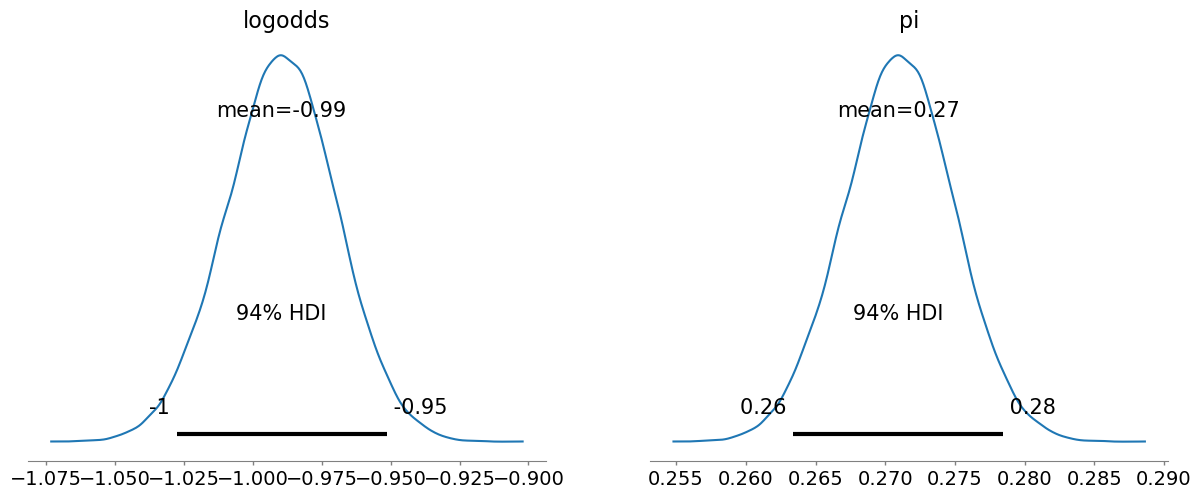

In [53]:
from arviz import plot_posterior

_ = plot_posterior(model_fit)

# Summing Up

This has been a whirlwind tour of foundational concepts in probability and statistics. I recognize that it went fast, especially if you are rusty on these concepts or haven't seen some of them at all. When we need any of them again, I'll make sure to remind you of them, but I encourage you also to return to this notebook for a more in-depth reminder of the technical machinery.